In [35]:
import os
import ast
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
import joblib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from sklearn.pipeline import make_pipeline

In [36]:
def load_data(angles = [0], type = 'degree' , axis = 'roll'):
    
     # Add more angles if needed
    rssi_values = []
    roll = 0
    pitch = 0
    yaw = 0

    # Construct the file path and load data
    for angle in angles:
        file_path = f'RSSI_Data/rssi_list_{angle}_{type}.txt'
        if axis == 'roll':
            roll = angle
        if axis == 'pitch':
            pitch = angle
        if axis == 'yaw':
            yaw = angle
        # Check if the file exists
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    try:
                        item = ast.literal_eval(line)
                        
                      
                        x = (item[0]-1)**2
                        y = (item[1]-1)**2
                        
                        d = np.sqrt((x+y))

                        tx_power = -45
                        item.append(tx_power)
                        item.append(roll)
                        item.append(pitch)
                        item.append(yaw)
                        item.append(d)
                        item = item[2:]
                        rssi_values.append(item)
                        
                        
                    except (ValueError, SyntaxError) as e:
                        #print(f"Skipping malformed line in {file_path}: {line} - {e}")
                        continue
                    
            
        else:
            print(f"File {file_path} does not exist.")


    # Convert the combined list to a numpy array
    points = np.array(rssi_values, dtype=float)

    # Remove rows with any `nan` values
    points = points[~np.isnan(points).any(axis=1)]

    print("Filtered data as numpy array (without `nan` rows):")
    
    return points

In [37]:
angle = [0]
type = 'interpolation_data'
degree = 2

interpolation_data = load_data(angle,type)

distance = interpolation_data[:,6]
features = interpolation_data[:, 0:2]
print(distance)
print(features)

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(features, distance)
joblib.dump(poly_model, 'quadratic_distance_model.pkl')

Filtered data as numpy array (without `nan` rows):
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[[-17.06382979 -44.31914894]
 [-36.10344828 -48.        ]
 [-41.64485981 -50.        ]
 [-44.82051282 -50.        ]
 [-44.1011236  -50.        ]
 [-48.14285714 -47.        ]
 [-48.69158879 -45.81308411]
 [-54.31       -48.        ]
 [-56.52631579 -48.14912281]
 [-64.54166667 -47.40625   ]
 [-57.77922078 -48.        ]]


['quadratic_distance_model.pkl']

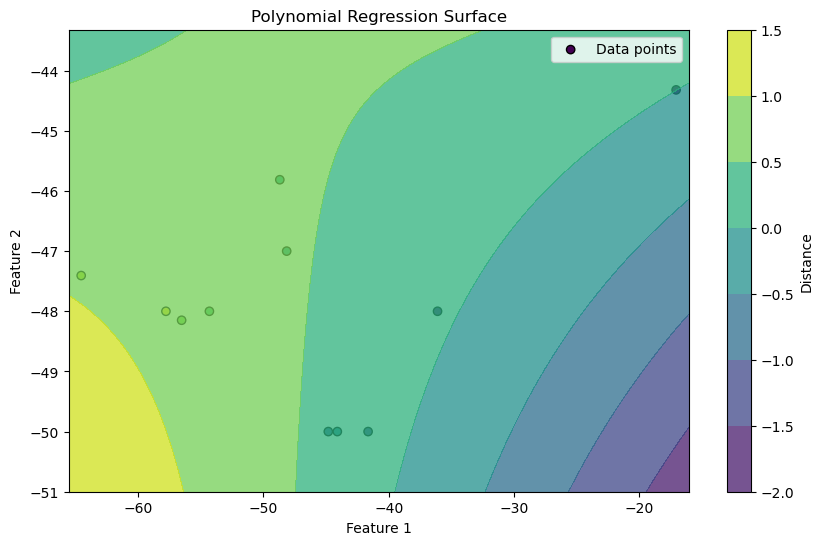

In [38]:
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict distances using the model on the mesh grid
Z = poly_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the data points and the polynomial surface
plt.figure(figsize=(10, 6))
plt.scatter(features[:, 0], features[:, 1], c=distance, cmap='viridis', edgecolor='k', label='Data points')
plt.contourf(xx, yy, Z, alpha=0.75, cmap='viridis')
plt.colorbar(label='Distance')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Polynomial Regression Surface')
plt.legend()
plt.savefig('plots/Multiparameter_Fit.jpg', format='jpeg')
plt.show()

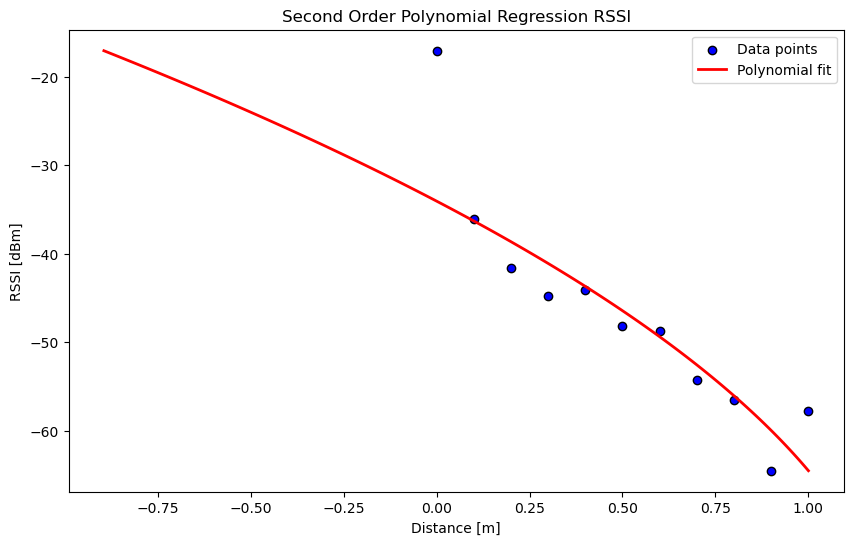

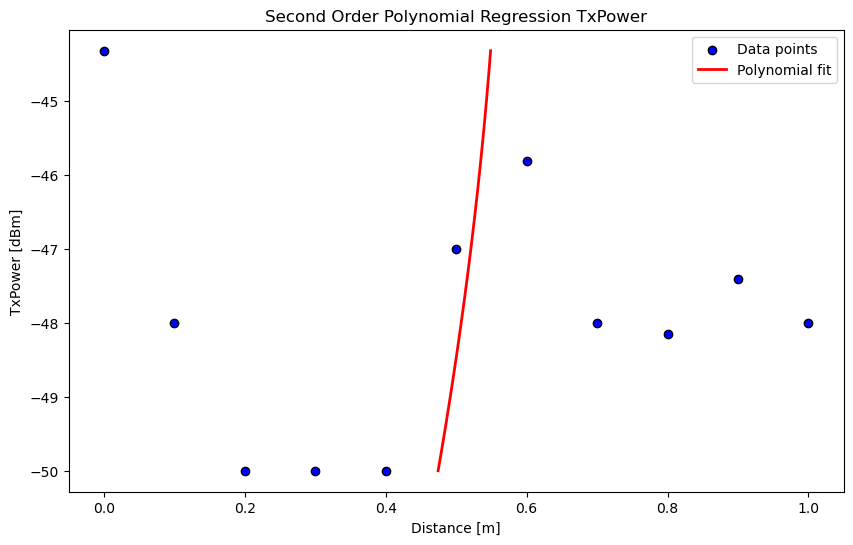

In [39]:
# Generate predictions for Feature 1
feature_1_range = np.linspace(features[:, 0].min(), features[:, 0].max(), 100)
feature_1_range_2d = np.c_[feature_1_range, np.full(feature_1_range.shape, features[:, 1].mean())]
predicted_distance_1 = poly_model.predict(feature_1_range_2d)

# Generate predictions for Feature 2
feature_2_range = np.linspace(features[:, 1].min(), features[:, 1].max(), 100)
feature_2_range_2d = np.c_[np.full(feature_2_range.shape, features[:, 0].mean()), feature_2_range]
predicted_distance_2 = poly_model.predict(feature_2_range_2d)

# Plotting the data points and the polynomial curve for Feature 1
plt.figure(figsize=(10, 6))
plt.scatter(distance,features[:, 0],  color='blue', edgecolor='k', label='Data points')
plt.plot(predicted_distance_1,feature_1_range,  color='red', linewidth=2, label='Polynomial fit')
plt.xlabel('Distance [m]')
plt.ylabel('RSSI [dBm]')
plt.title('Second Order Polynomial Regression RSSI')
plt.legend()
plt.savefig('plots/Multiparameter_Fit_RSSI.jpg', format='jpeg')
plt.show()

# Plotting the data points and the polynomial curve for Feature 2
plt.figure(figsize=(10, 6))
plt.scatter(distance, features[:, 1], color='blue', edgecolor='k', label='Data points')
plt.plot( predicted_distance_2,feature_2_range, color='red', linewidth=2, label='Polynomial fit')
plt.xlabel('Distance [m]')
plt.ylabel('TxPower [dBm]')
plt.title('Second Order Polynomial Regression TxPower')
plt.legend()
plt.savefig('plots/Multiparameter_Fit_TxPower.jpg', format='jpeg')
plt.show()

In [52]:
angle = [0]
type = 'interpolation_data'
degree = 2

interpolation_data = load_data(angle,type)

distance = interpolation_data[:,6]
features = (interpolation_data[:, 0] / interpolation_data[:, 1]).reshape(-1,1)
print(features)

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(features, distance)
joblib.dump(poly_model, 'quadratic_distance_model_modified.pkl')

Filtered data as numpy array (without `nan` rows):
[[0.3850216 ]
 [0.75215517]
 [0.8328972 ]
 [0.89641026]
 [0.88202247]
 [1.02431611]
 [1.0628315 ]
 [1.13145833]
 [1.17398433]
 [1.36145902]
 [1.20373377]]


['quadratic_distance_model_modified.pkl']

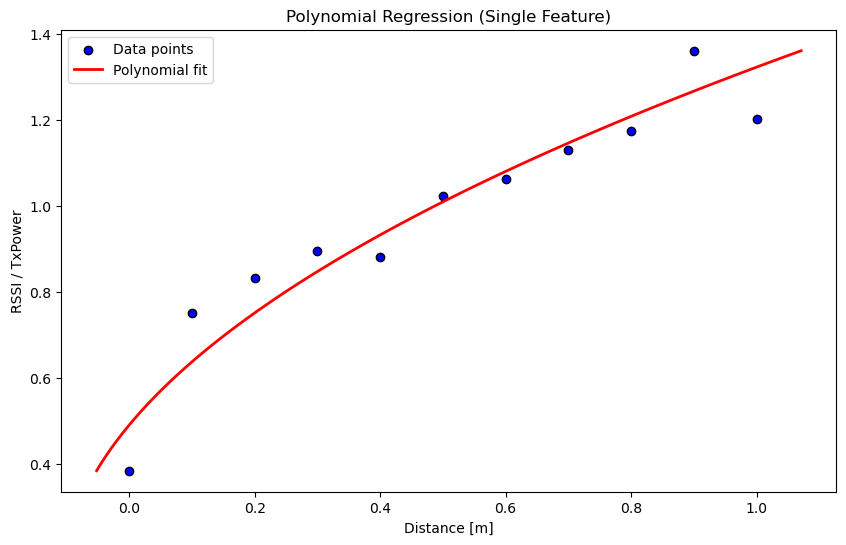

In [53]:
# Generate predictions for the feature range
feature_range = np.linspace(features.min(), features.max(), 100).reshape(-1, 1)
predicted_distance = poly_model.predict(feature_range)

# Plotting the data points and the polynomial curve
plt.figure(figsize=(10, 6))
plt.scatter(distance, features, color='blue', edgecolor='k', label='Data points')
plt.plot(predicted_distance,feature_range,  color='red', linewidth=2, label='Polynomial fit')
plt.xlabel('Distance [m]')
plt.ylabel('RSSI / TxPower')
plt.title('Polynomial Regression (Single Feature)')
plt.legend()

In [54]:
print(poly_model.predict([[0.8]]))

[0.24812382]


Filtered data as numpy array (without `nan` rows):
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
 0.3  0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.4  0.4  0.4
 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.45 0.45 0.45 0.45 0.45 0.45 0.45
 0.45 0.45 0.45 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.55
 0.55 0.55 0.55 0.55 0.55 0.55 0.55 0.55 0.55 0.6  0.6  0.6  0.6  0.6
 0.6  0.6  0.6  0.6  0.6  0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65
 0.65 0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.8  0.8  0.8  0.8  0.8  0.8  0.8
 0.8  0.8  0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.

/tmp/ipykernel_138582/3509209528.py:20: RuntimeWarning: divide by zero encountered in log
  return a * np.log(b*x)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


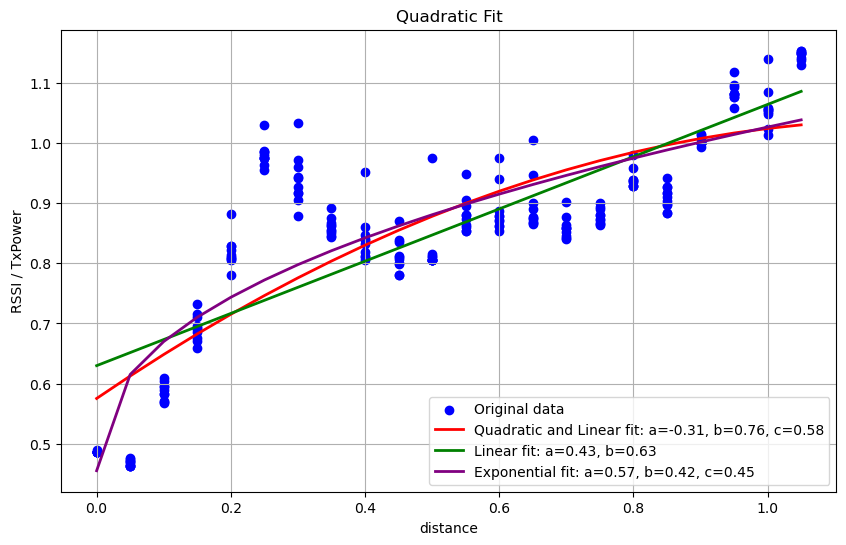

In [68]:
angle = [0]
type = 'interpolation_data_big_data'


interpolation_data = load_data(angle,type)



distance = interpolation_data[:,6]
features = interpolation_data[:,0] / interpolation_data[:,1]

print(distance)
print(features)

# Define the logarithmic function
def quadratic_function(x, a, b,c):
    return a*x**2 + b*x +c 

def log(x,a,b):
    return a * np.log(b*x)

def linear_function(x,a,b):
    return a*x + b

def exponential_function(x,A,B,C):
     return A * (np.power(x,B)) + C

# Fit the logarithmic function to the data
params, covariance = curve_fit(quadratic_function, distance ,features)
# Fit the logarithmic function to the data
params_ln, covariance_ln = curve_fit(log, distance, features)

params_lin, covariance_lin = curve_fit(linear_function, distance,features)

params_exp, covariance_exp = curve_fit(exponential_function, distance,features)

# Extract parameters
a_fit, b_fit, c_fit = params
a_ln,b_ln = params_ln
a_lin,b_lin = params_lin
a_exp,b_exp,c_exp = params_exp

# Predict y values using the fitted parameters
y_fit = quadratic_function(distance, a_fit, b_fit,c_fit)
y_fit_ln = log(distance, a_ln, b_ln)
y_fit_lin = linear_function(distance,a_lin,b_lin)
y_fit_exp = exponential_function(distance,a_exp,b_exp,c_exp)

# Plotting the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(distance, features, color='blue', label='Original data')
plt.plot(distance, y_fit, color='red', linewidth=2, label=f'Quadratic and Linear fit: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}')
plt.plot(distance, y_fit_lin, color='green', linewidth=2, label=f'Linear fit: a={a_lin:.2f}, b={b_lin:.2f}')
plt.plot(distance, y_fit_exp, color='purple', linewidth=2, label=f'Exponential fit: a={a_exp:.2f}, b={b_exp:.2f}, c={c_exp:.2f}')
plt.xlabel('distance')
plt.ylabel('RSSI / TxPower')
plt.title('Quadratic Fit')
plt.legend()
plt.grid(True)
plt.savefig('plots/Quadratic_fit_linear_fit.jpg', format='jpeg')
plt.show()


